In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*2)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.0.252:45456' processes=28 threads=28, memory=447.16 GiB>

________________
### Read first: 
In this notebook, some basic information (e.g., bathymetry of the model domain, record-mean/max/min mixed layer depth, snapshots of u,v,w,b) are given in section 2. 

Section 3 displays some estimates based on the model output such as Rossby number, lateral buoyancy gradient, PV, Frontogenesis function. 

Raw outputs and 1-day low-pass filtered data are used in Section 3.

_________
# 1. Read dataset



In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [6]:
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)

ds_KPP = xr.open_zarr(out_dir_zarr+'Surface_variable/KPPhbl_total_rechunk.zarr')
ds_Eta = xr.open_zarr(out_dir_zarr+'Surface_variable/Eta_total_rechunk.zarr')
ds_taux = xr.open_zarr(out_dir_zarr+'Surface_variable/oceTAUX_total_rechunk.zarr')
ds_tauy = xr.open_zarr(out_dir_zarr+'Surface_variable/oceTAUY_total_rechunk.zarr')
ds_fwflx = xr.open_zarr(out_dir_zarr+'Surface_variable/oceFWflx_total_rechunk.zarr')
ds_qnet = xr.open_zarr(out_dir_zarr+'Surface_variable/oceQnet_total_rechunk.zarr')
ds_qsw = xr.open_zarr(out_dir_zarr+'Surface_variable/oceQsw_total_rechunk.zarr')
ds_sflux = xr.open_zarr(out_dir_zarr+'Surface_variable/oceSflux_total_rechunk.zarr')

ds_surface = xr.merge([ds_KPP,ds_Eta,ds_taux,ds_tauy,ds_fwflx,ds_qnet,ds_qsw,ds_sflux,grid])

In [7]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


In [8]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')

In [9]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

In [10]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_1day_lowpass_filter.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_1day_lowpass_filter.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...            ...
    dxG           (lat_g, lon) float32 ...
    dyG           (lat, lon_g) float32 ...
    rA            (lat, lon) float32 ...
    rAz           (lat_g, lon_g) float32 ...
    rAw           (lat, lon_g) float32 ...
    rAs           (lat_g, lon) float32 ...
Data variables:
    U_low_filter  (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V_l

# 2. Basics

/dev/shm/pbs.585459.datarmor0/ipykernel_10332/528651820.py:8: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')


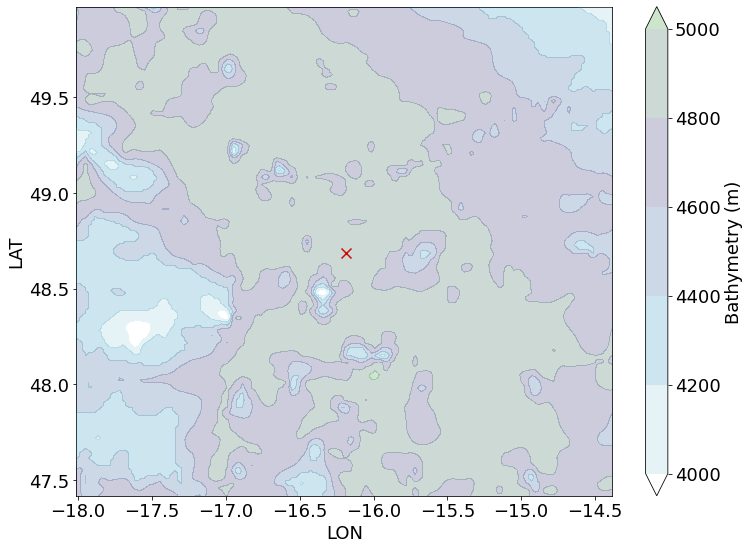

In [16]:
font_size = 18
bathymetry = ds.Depth

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
cax=bathymetry.isel(lat=slice(1,-1),lon=slice(1,-1)).plot.contourf(x='lon', y='lat', vmin=4000, vmax=5000, cmap='ocean_r',
                                                                   alpha=0.2, zorder=6, add_colorbar = False, levels = [4000,4200,4400,4600,4800,5000])
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Bathymetry (m)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)
#plt.contourf(x_topo,y_topo,topo[i0:i1,j0:j1],cmap='ocean_r', alpha=0.2, zorder=1)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Bathymetry_map.png')

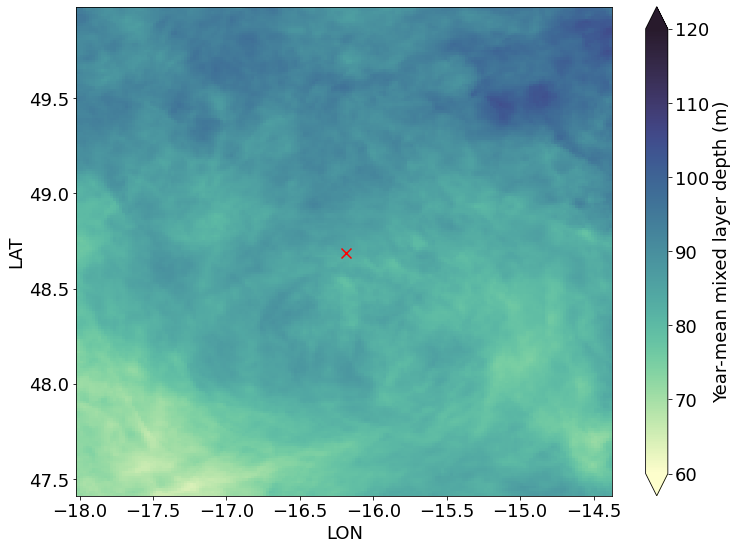

In [28]:
font_size = 18

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
cax=ds.mld_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time']).plot(x='lon', y='lat', vmin=60, vmax=120, cmap=cm.deep, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Year-mean mixed layer depth (m)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/MLD_map.png')

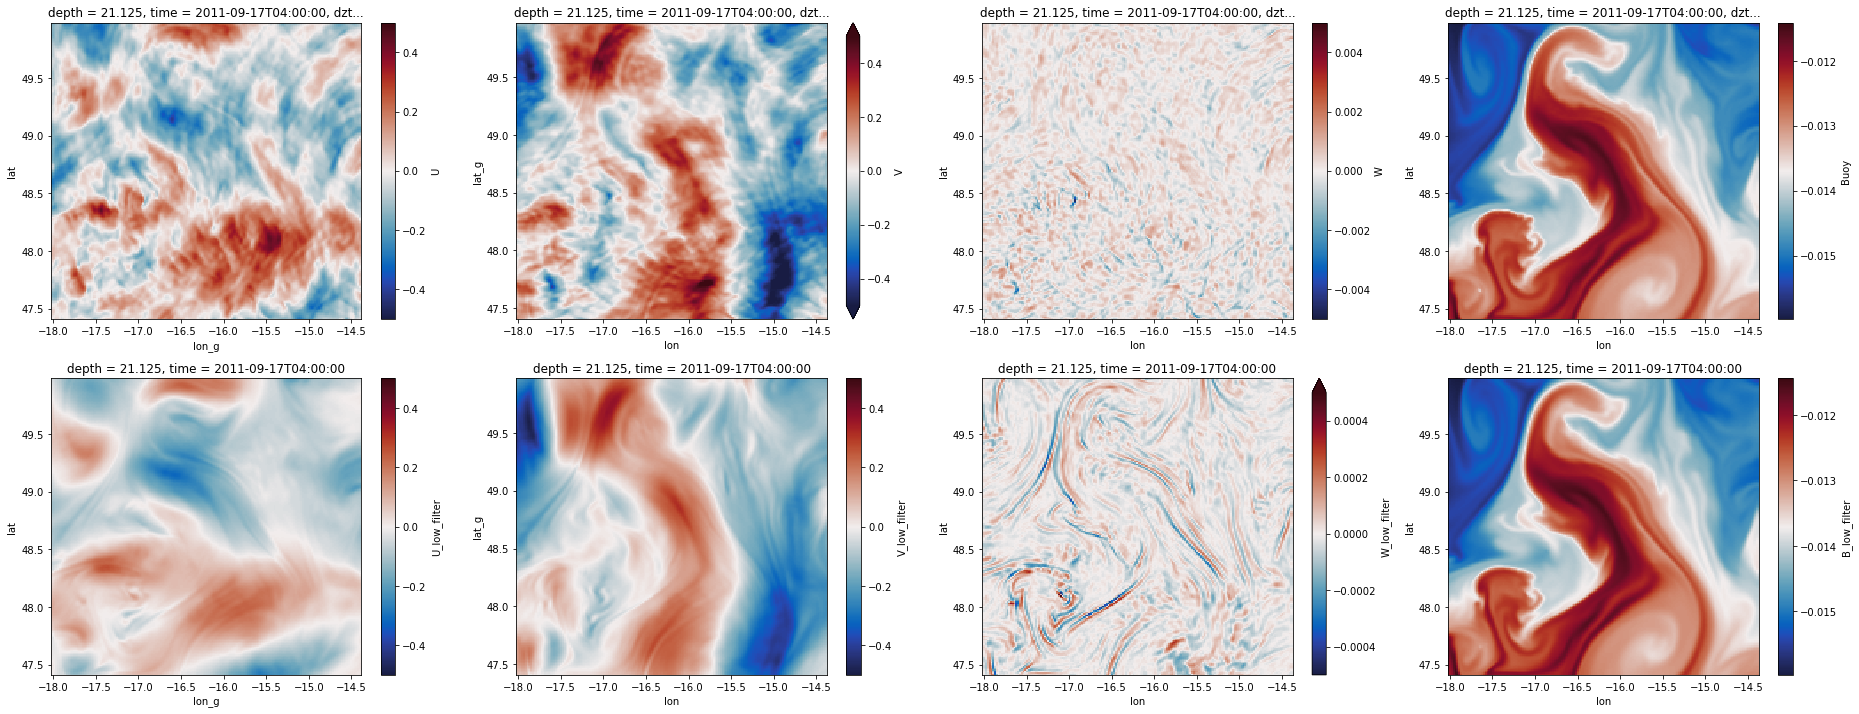

In [22]:
fig = plt.figure(figsize=(32,12))

plt.subplot(241)
ds.U.isel(lat=slice(1,-1),lon_g=slice(1,-1), time=100, depth=10).plot(x='lon_g', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(242)
ds.V.isel(lat_g=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat_g', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(243)
ds.W.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', vmin=-0.005, vmax=0.005, cmap=cm.balance)
plt.subplot(244)
ds.Buoy.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

plt.subplot(245)
ds_filter.U_low_filter.isel(lat=slice(1,-1),lon_g=slice(1,-1), time=100, depth=10).plot(x='lon_g', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(246)
ds_filter.V_low_filter.isel(lat_g=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat_g', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(247)
ds_filter.W_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', vmin=-0.0005, vmax=0.0005, cmap=cm.balance)
plt.subplot(248)
ds_filter.B_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

(500.0, 0.0)

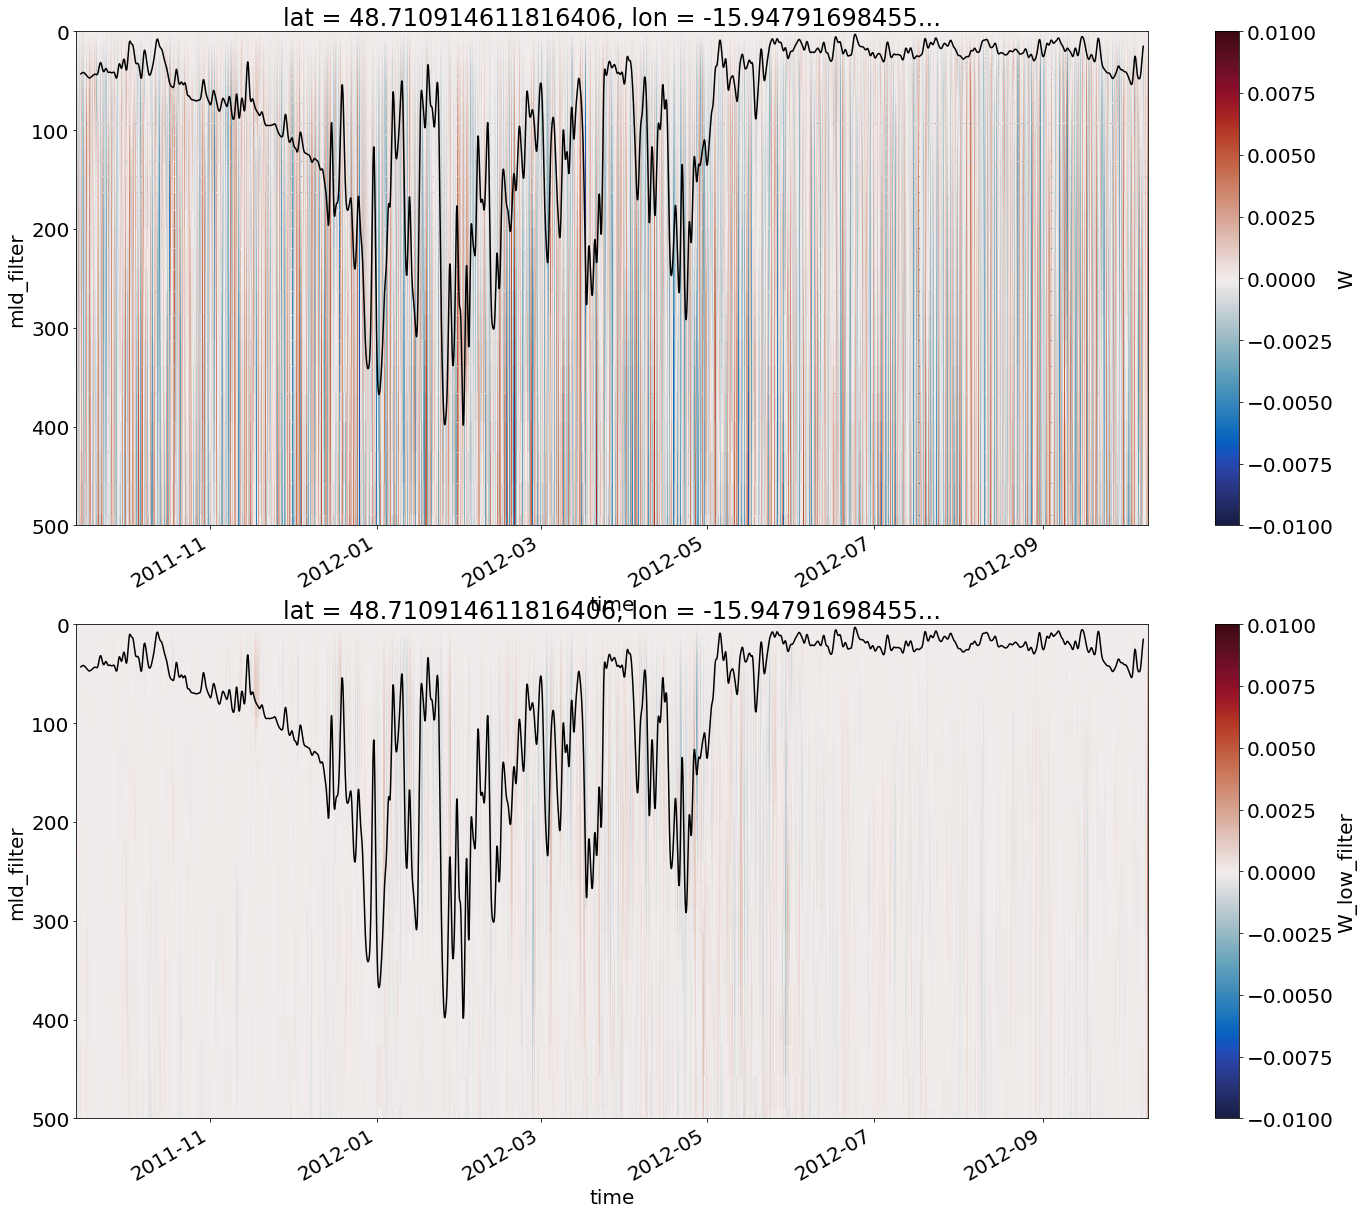

In [26]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(24,20))

ax = plt.subplot(211)
ds.W.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.01, vmax=0.01,cmap=cm.balance, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)
ax.set_ylim([500., 0.])

ax = plt.subplot(212)
ds_filter.W_low_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-0.01, vmax=0.01,cmap=cm.balance, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)
ax.set_ylim([500., 0.])

## KE

In [19]:
KE = (gridx.interp(ds['U']**2,'X') + gridx.interp(ds['V']**2,'Y'))/2 # KE
KE_filter = (gridx.interp(ds_filter['U_low_filter']**2,'X') + gridx.interp(ds_filter['V_low_filter']**2,'Y'))/2 # KE_filter
KE

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

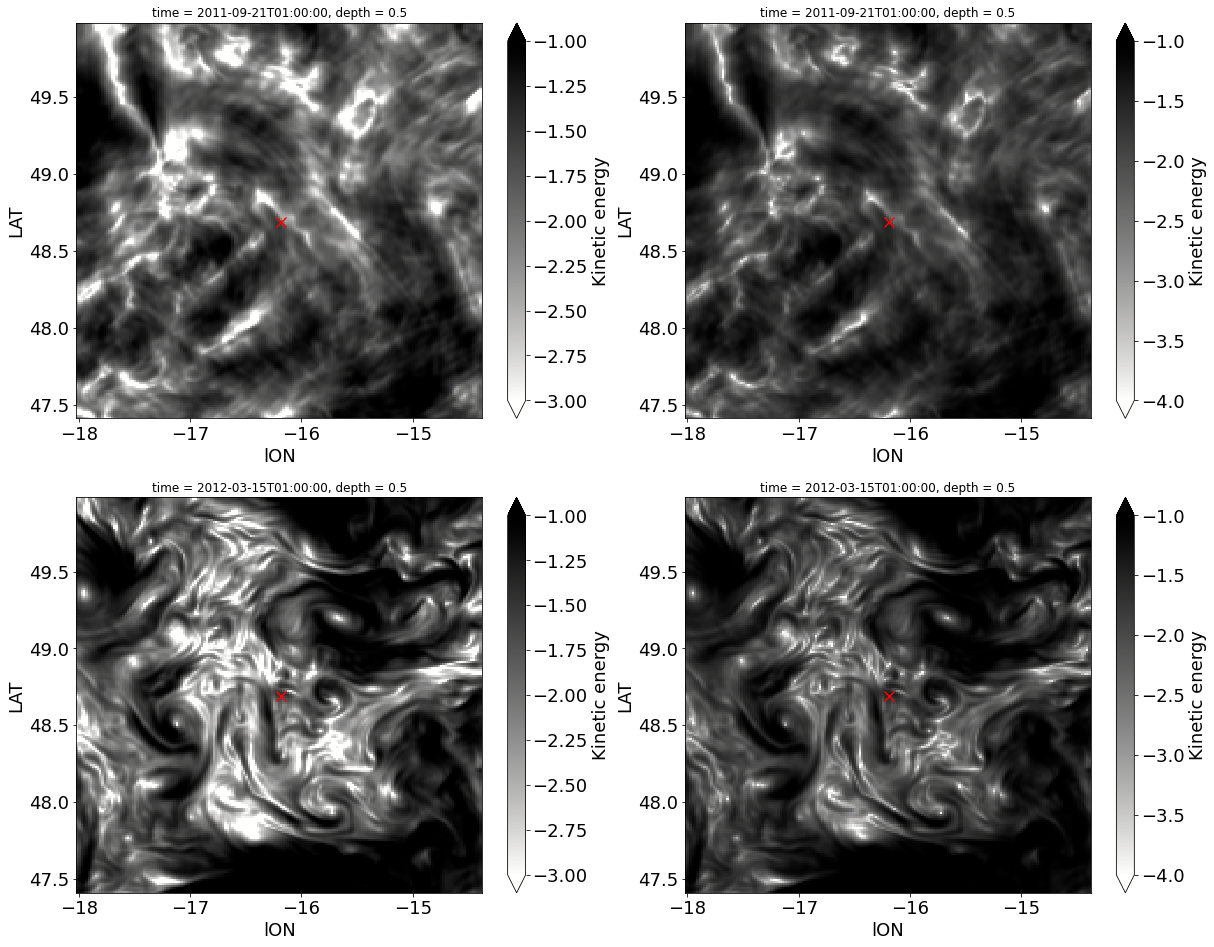

In [20]:
font_size = 18

fig = plt.figure(figsize=(20,16))

ax = plt.subplot(221)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-3, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-4, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-3, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-4, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

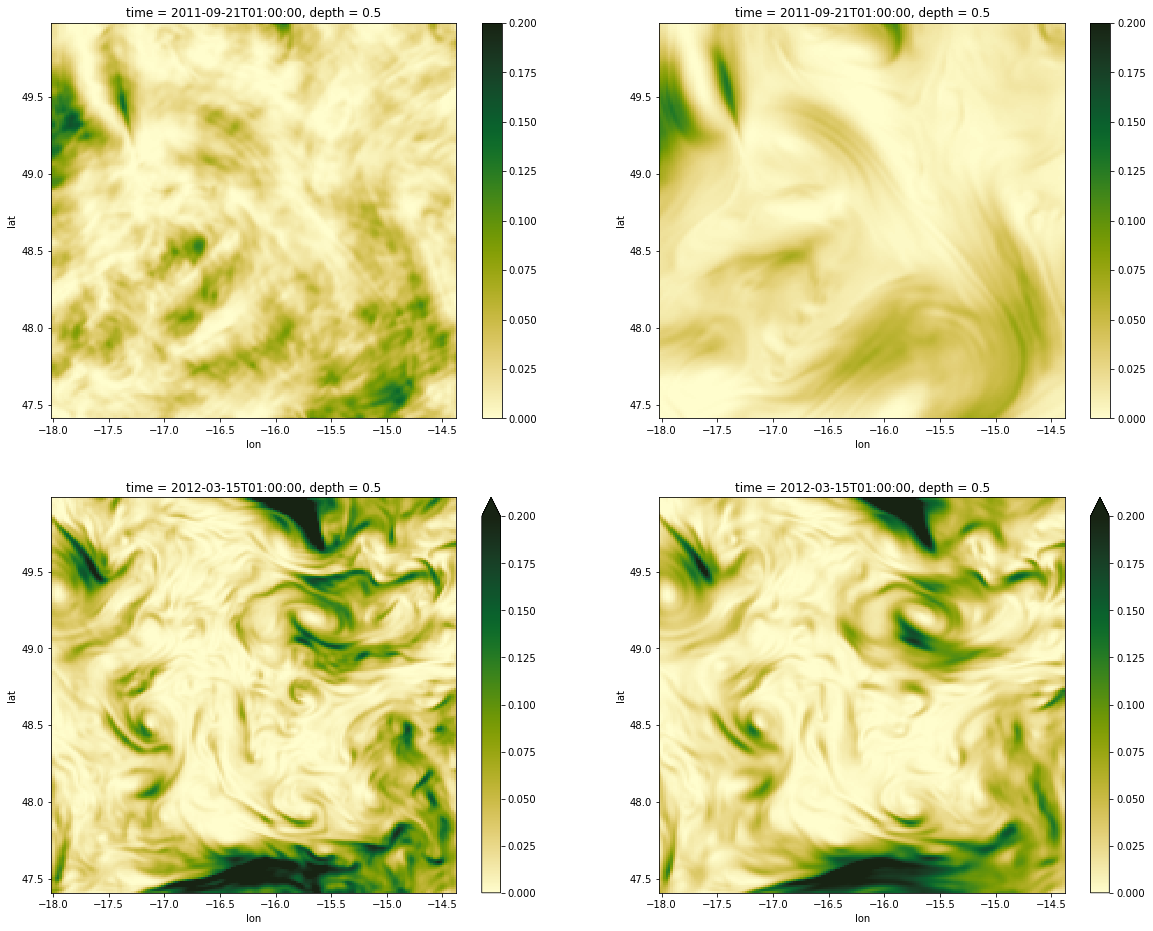

In [21]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
KE.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)
plt.subplot(222)
KE_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)
plt.subplot(223)
KE.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)
plt.subplot(224)
KE_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)

# 3. Parameter

## 3.1 Rossby number

In [29]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_f = (zeta/f)

zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_filter_f = (zeta_filter/f)

print(zeta_f)

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(1, 176, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XG       (lat_g, lon_g) float32 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    YG       (lat_g, lon_g) float32 47.4 47.4 47.4 47.4 ... 49.98 49.98 49.98
    rAz      (lat_g, lon_g) float32 2.303e+06 2.303e+06 ... 2.09e+06 2.09e+06


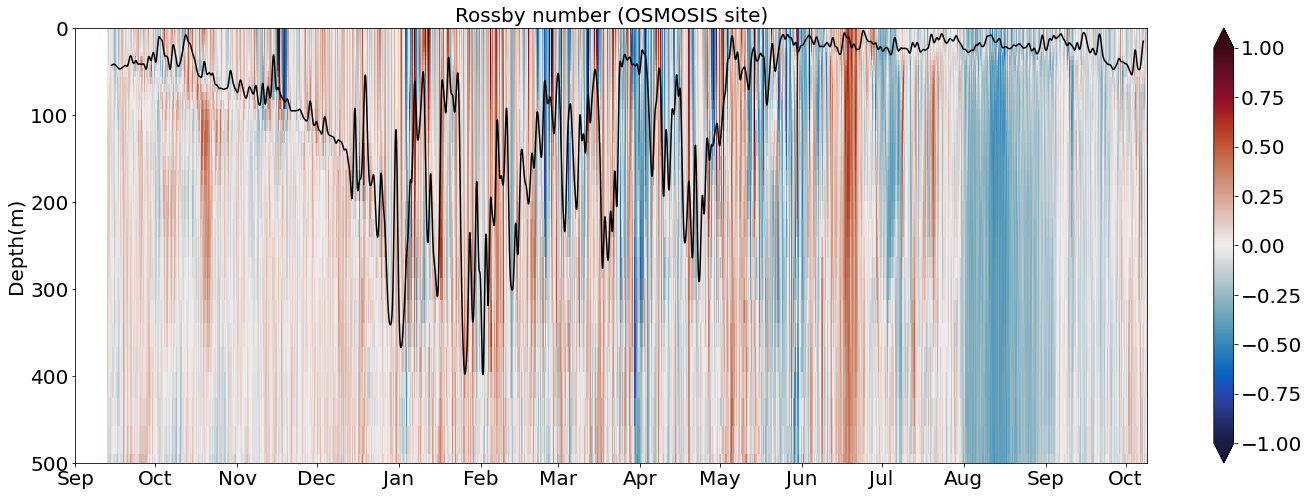

In [42]:
plt.rc('font', size=20) 
labels = ['Mixed layer depth']

font_size=20
fig, ax = plt.subplots(figsize=(24,8))

ax = plt.subplot(111)
zeta_f.isel(lat_g=100,lon_g=100).plot(x='time', y='depth',vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False, label=labels[0])
ax.set_ylim([500., 0.])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Rossby number', fontsize=font_size)
ax.set_ylabel('Depth(m)',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.set_title('Rossby number (OSMOSIS site)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-10-09'])
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09', '2012-10'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'], ha='center')
plt.xticks(rotation=0)
#ax.grid()
#ax.legend(); 
#ax.legend(prop={'size': font_size})

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Rossby_number_timeseries.png')

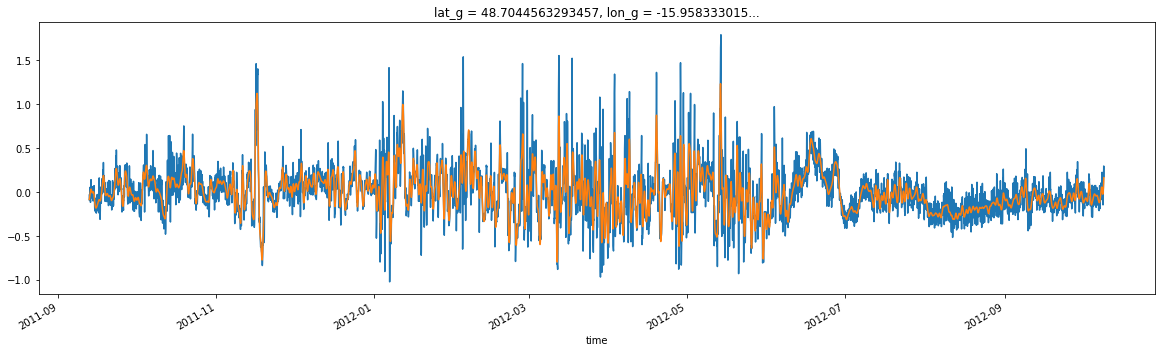

In [12]:
fig = plt.figure(figsize=(20,5))

zeta_f.isel(lat_g=100, lon_g=100,depth=1).plot()
zeta_filter_f.isel(lat_g=100, lon_g=100,depth=1).plot()

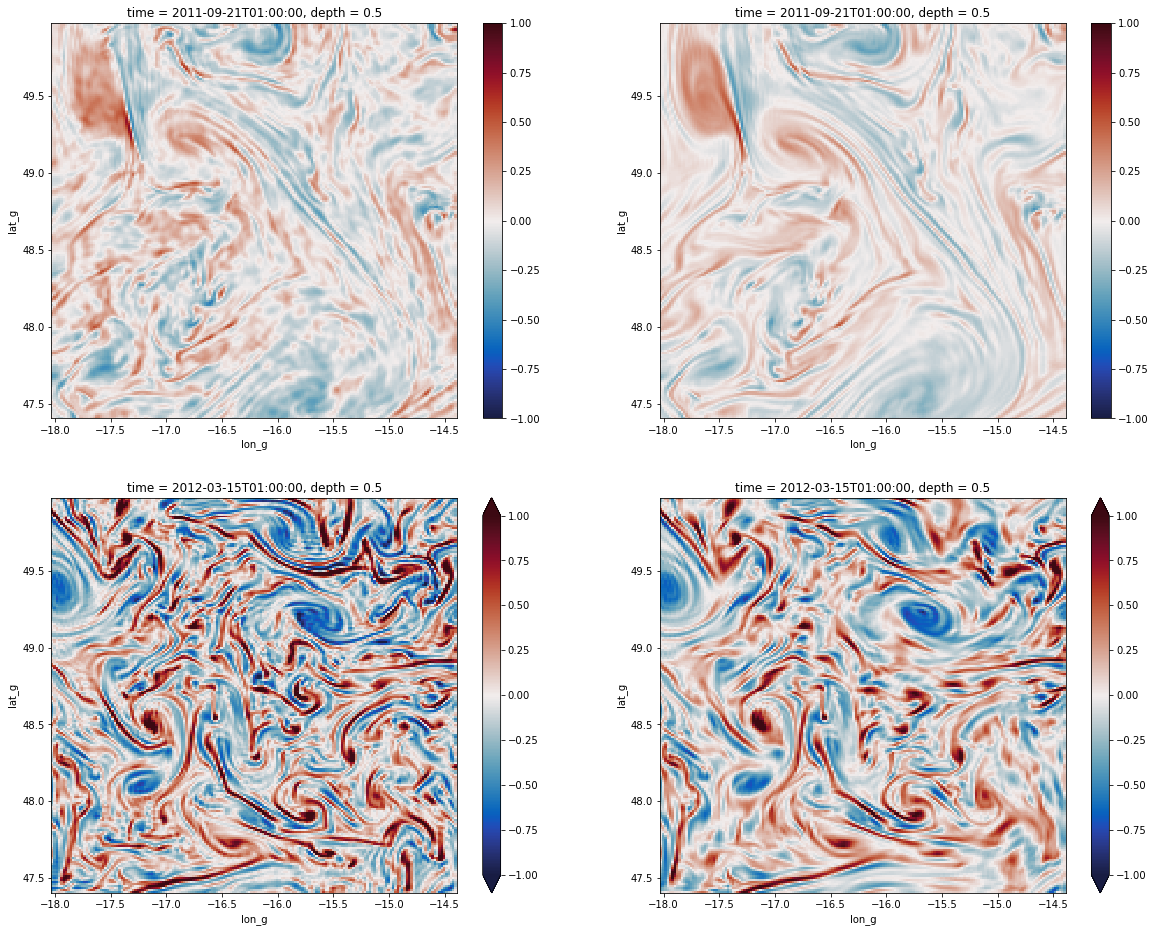

In [18]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(222)
zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)

plt.subplot(223)
zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(224)
zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)

## 3.2 Horizontal strain

### Note that this is not strain rate which only has positive values

In [30]:
strain = (gridx.diff(ds['U'] * ds.dyG, 'X') - gridx.diff(ds['V']* ds.dxG, 'Y')) / ds.rA
strain_f = (strain/f_ij)

strain_filter = (gridx.diff(ds_filter['U_low_filter'] * ds.dyG, 'X') - gridx.diff(ds_filter['V_low_filter']* ds.dxG, 'Y')) / ds.rA
strain_filter_f = (strain_filter/f_ij)

strain_f

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

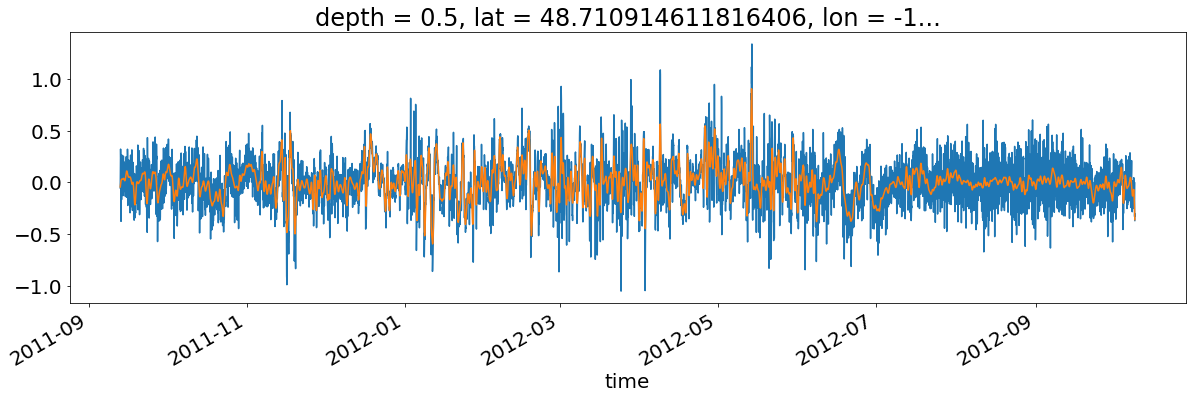

In [36]:
fig = plt.figure(figsize=(20,5))

strain_f.isel(lat=100, lon=100,depth=0).plot()
strain_filter_f.isel(lat=100, lon=100,depth=0).plot()

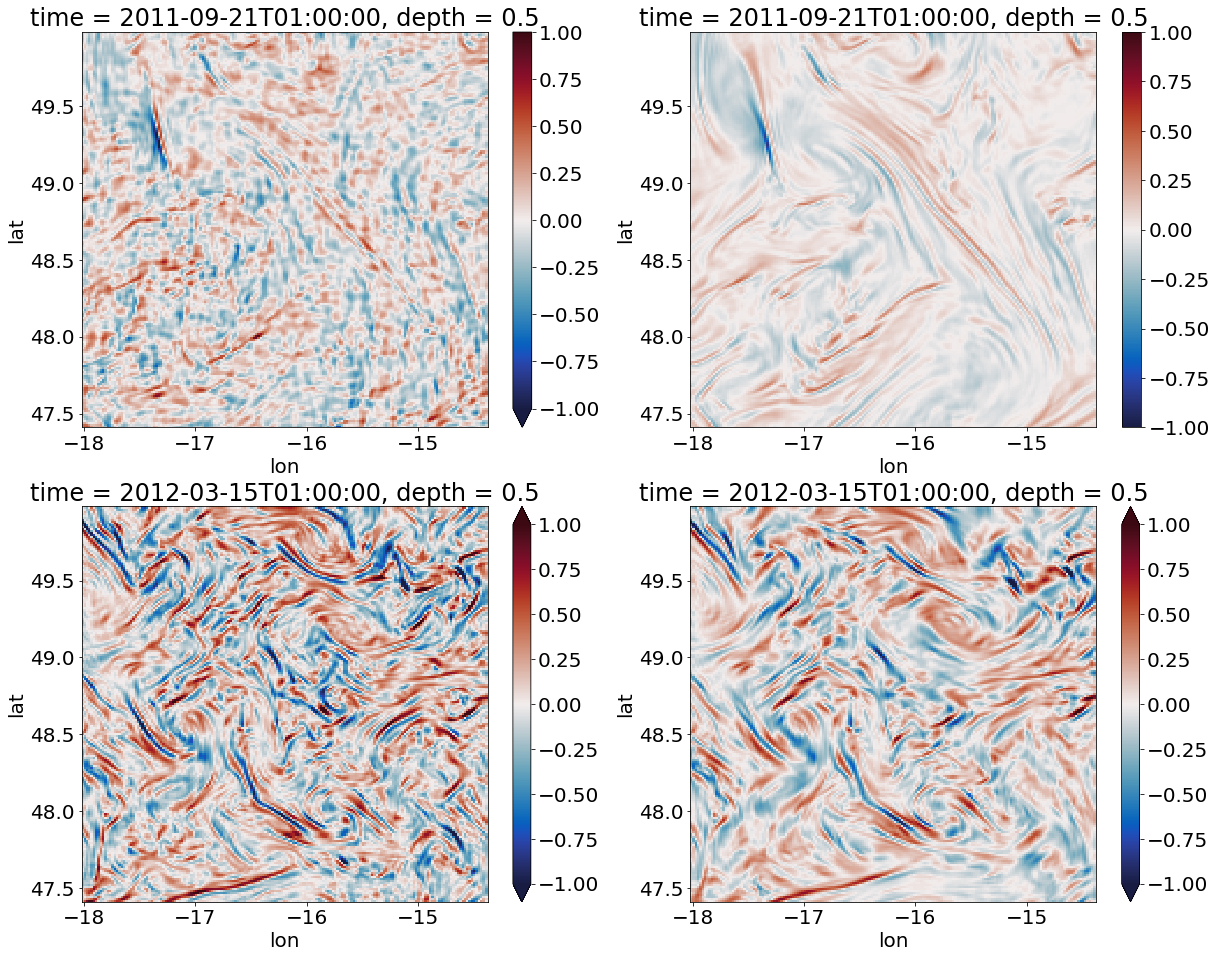

In [31]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
strain_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(222)
strain_filter_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)

plt.subplot(223)
strain_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(224)
strain_filter_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)

## 3.4 Horizontal divergence

In [32]:
vel_div_components = gridx.diff_2d_vector({'X': ds.dyG * ds['U'], 'Y': ds.dxG * ds['V']}, boundary='extend')
vel_div = (vel_div_components['X'] + vel_div_components['Y'])/ds.rA
vel_div_f = (vel_div/f_ij)
vel_div_f

vel_div_components_filter = gridx.diff_2d_vector({'X': ds.dyG * ds_filter['U_low_filter'], 'Y': ds.dxG * ds_filter['V_low_filter']}, boundary='extend')
vel_div_filter = (vel_div_components_filter['X'] + vel_div_components_filter['Y'])/ds.rA
vel_div_filter_f = (vel_div_filter/f_ij)

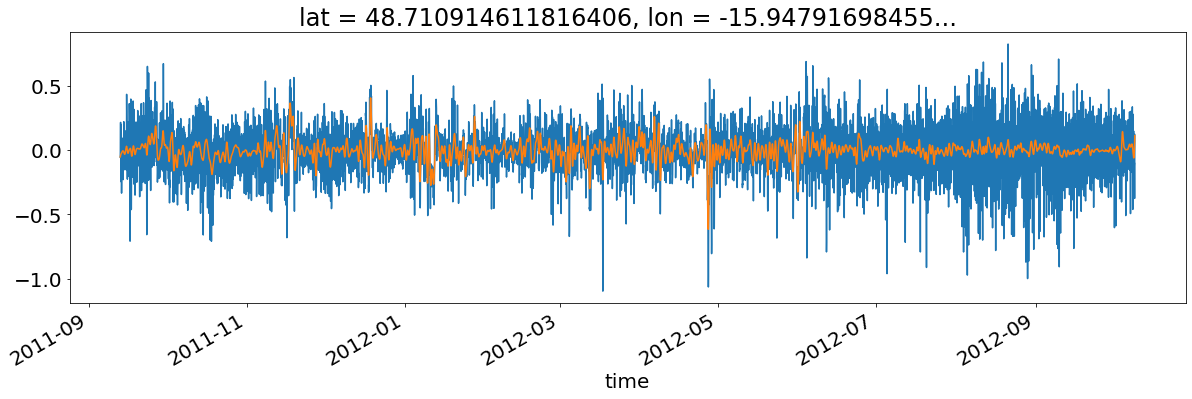

In [35]:
fig = plt.figure(figsize=(20,5))

vel_div_f.isel(lat=100, lon=100,depth=0).plot()
vel_div_filter_f.isel(lat=100, lon=100,depth=0).plot()

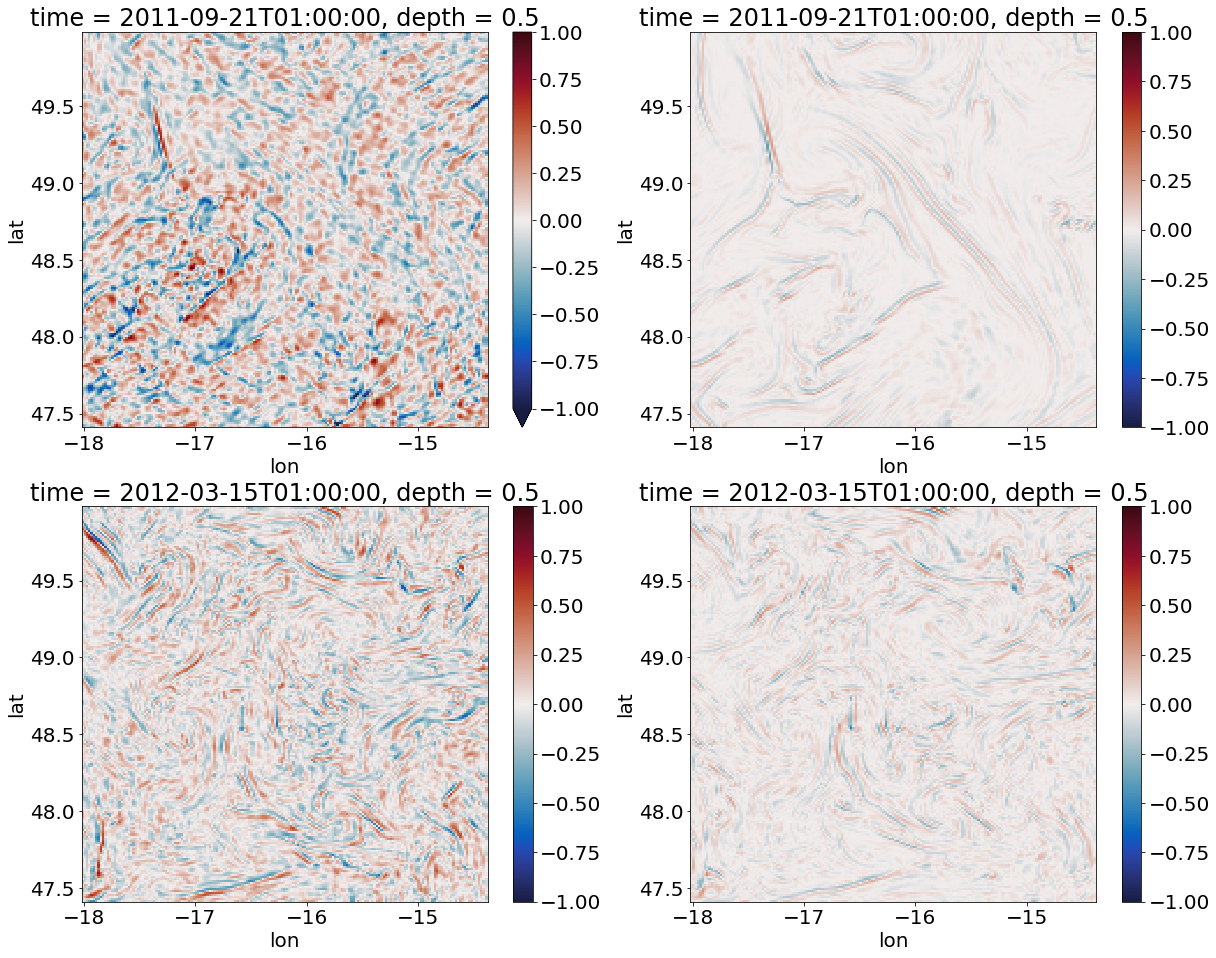

In [34]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
vel_div_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(222)
vel_div_filter_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)

plt.subplot(223)
vel_div_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(224)
vel_div_filter_f.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-1, vmax=1, cmap=cm.balance)

## 3.5 lateral gradient

In [37]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')
lateral_buoyancy_gradient = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)

db_dx_filter = gridx.diff(ds_filter['B_low_filter'],'X')/ds.dxC     # db/dx
db_dx_ij_filter = gridx.interp(db_dx_filter,'X')
db_dy_filter = gridx.diff(ds_filter['B_low_filter'],'Y')/ds.dyC     # db/dy
db_dy_ij_filter = gridx.interp(db_dy_filter,'Y')
lateral_buoyancy_gradient_filter = np.sqrt(db_dx_ij_filter*db_dx_ij_filter + db_dy_ij_filter*db_dy_ij_filter)

lateral_buoyancy_gradient

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<sqrt, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

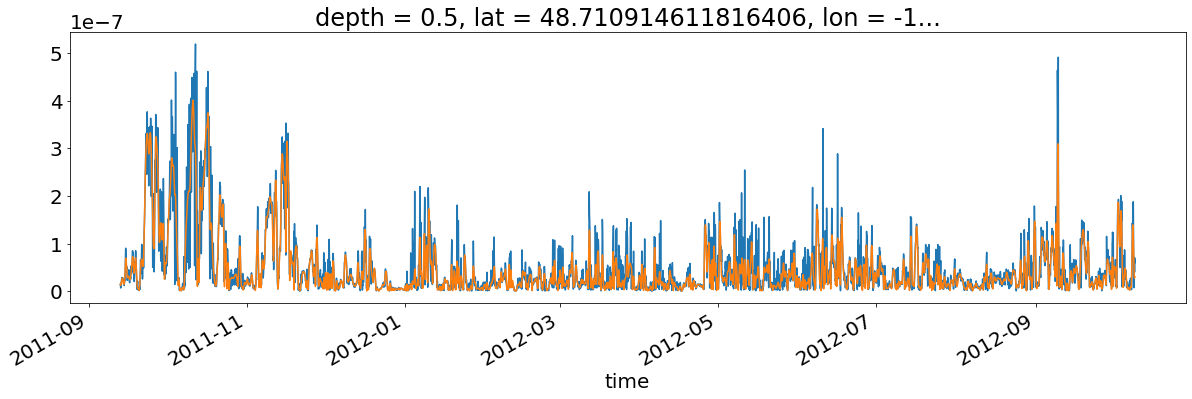

In [38]:
fig = plt.figure(figsize=(20,5))

lateral_buoyancy_gradient.isel(lat=100, lon=100,depth=0).plot()
lateral_buoyancy_gradient_filter.isel(lat=100, lon=100,depth=0).plot()

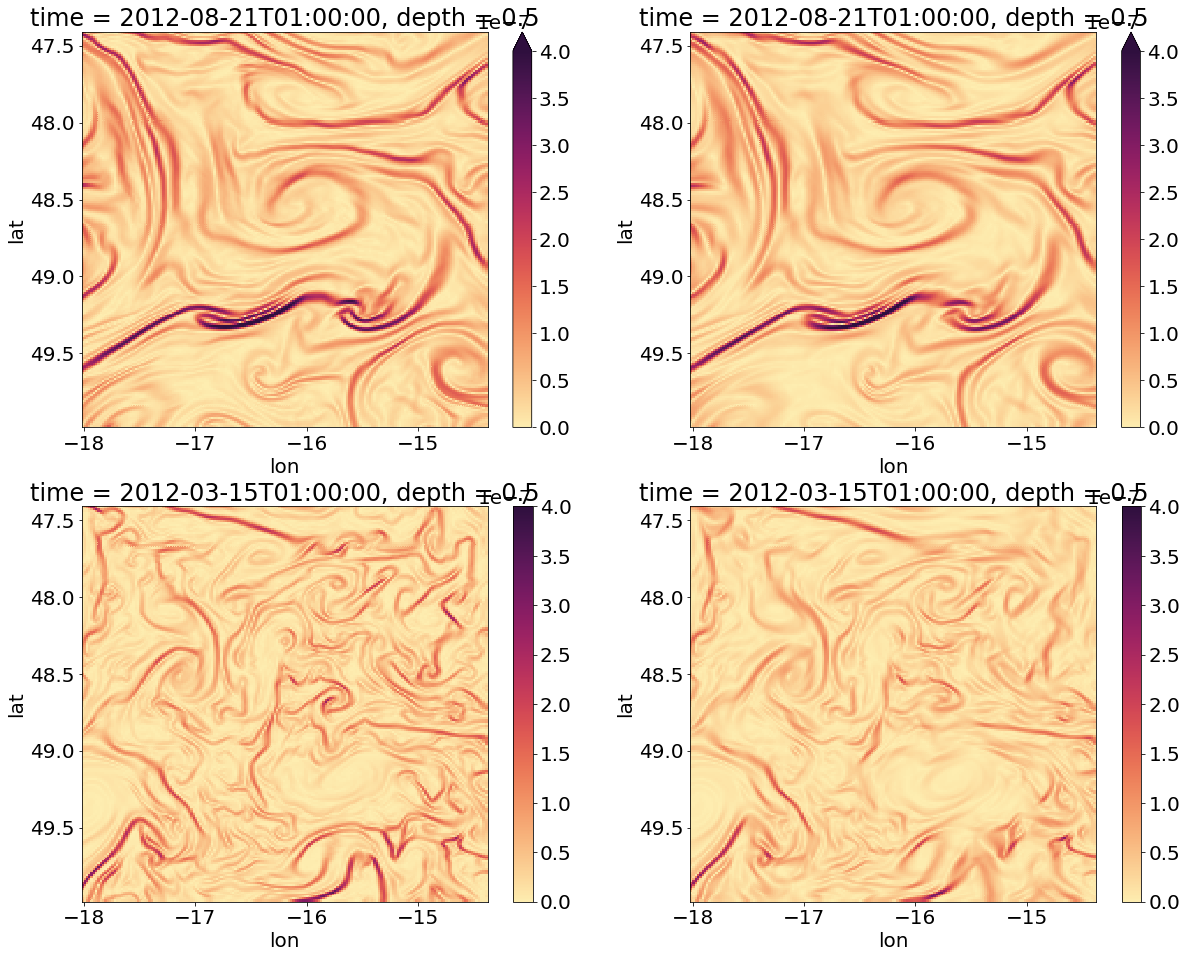

In [40]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
lateral_buoyancy_gradient.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-08-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)
plt.subplot(222)
lateral_buoyancy_gradient_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-08-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)

plt.subplot(223)
lateral_buoyancy_gradient.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)
plt.subplot(224)
lateral_buoyancy_gradient_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)

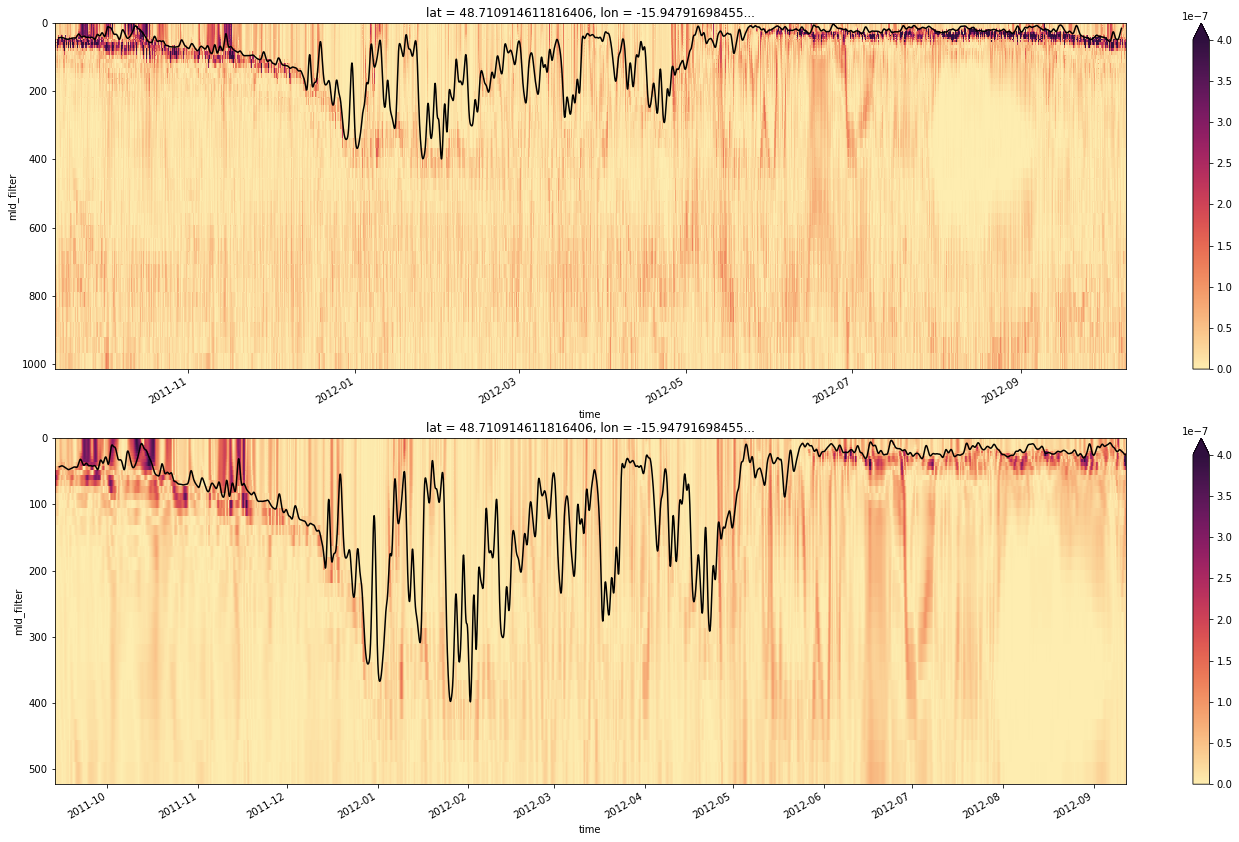

In [21]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
lateral_buoyancy_gradient.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=4e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
lateral_buoyancy_gradient_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=4e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 3.6 PV

In [35]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_i =  gridx.interp(zeta,'X')
zeta_ij =  gridx.interp(zeta_i,'Y')

db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)

PV = (f_ij + zeta_ij)*db_dz - (db_dx_ij**2 + db_dy_ij**2)/f_ij
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
PV = PV.chunk(chunks)
PV

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<rechunk-merge, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(201, 177, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [37]:
zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_i_filter =  gridx.interp(zeta_filter,'X')
zeta_ij_filter =  gridx.interp(zeta_i_filter,'Y')

db_dz_left_filter = -1*gridx.diff(ds_filter.B_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz_filter = gridx.interp(db_dz_left_filter,'Z', boundary='fill')
db_dz_filter = db_dz_filter.astype(np.float32)

PV_filter = (f_ij + zeta_ij_filter)*db_dz_filter - (db_dx_ij_filter**2 + db_dy_ij_filter**2)/f_ij
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
PV_filter = PV_filter.chunk(chunks)
PV_filter

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<rechunk-merge, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(201, 177, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

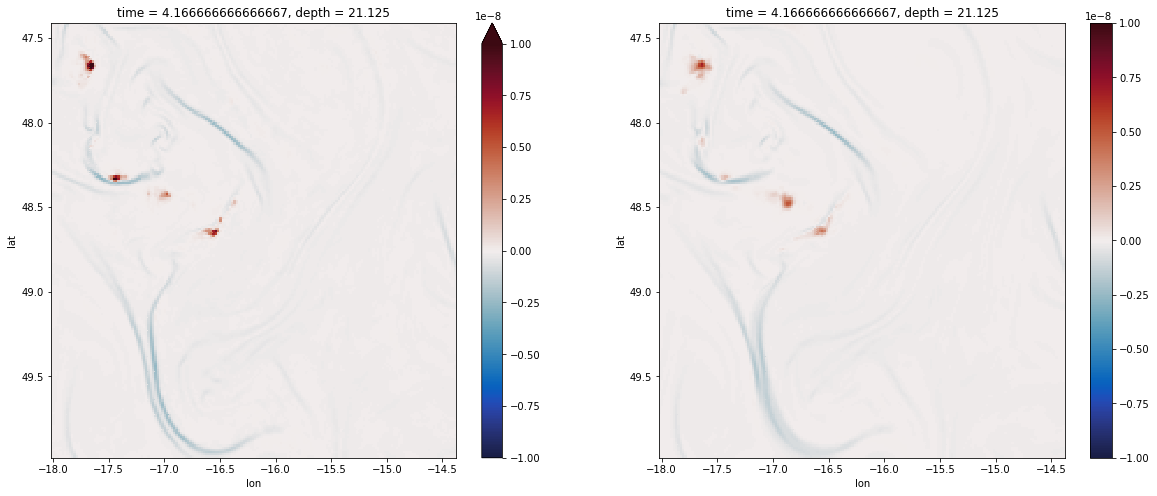

In [38]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
PV.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-8, vmax=1e-8,cmap=cm.balance, yincrease=False)
plt.subplot(122)
PV_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-8, vmax=1e-8,cmap=cm.balance, yincrease=False)

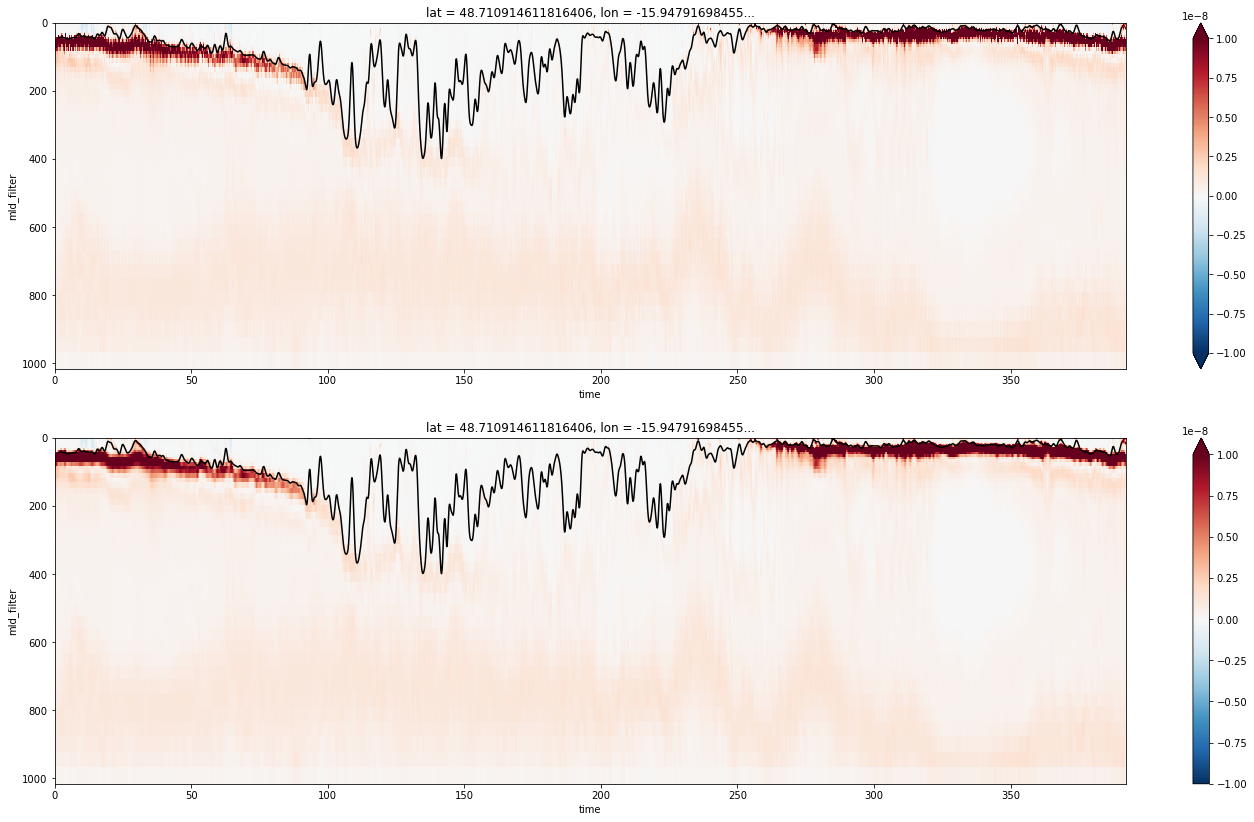

In [39]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
PV.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
PV_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 3.7 Richardson number

In [44]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)

dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1 = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz = gridx.interp(dU_dz_1,'X')
dU_dz = dU_dz.astype(np.float32)

dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1 = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz = gridx.interp(dV_dz_1,'Y')
dV_dz = dV_dz.astype(np.float32)

Ri = db_dz/(dU_dz**2 + dV_dz**2)
Ri

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [45]:
db_dz_left_filter = -1*gridx.diff(ds_filter.B_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz_filter = gridx.interp(db_dz_left_filter,'Z', boundary='fill')
db_dz_filter = db_dz_filter.astype(np.float32)

dU_dz_left_filter = -1*gridx.diff(ds_filter.U_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1_filter = gridx.interp(dU_dz_left_filter,'Z', boundary='fill')
dU_dz_filter = gridx.interp(dU_dz_1_filter,'X')
dU_dz_filter = dU_dz_filter.astype(np.float32)

dV_dz_left_filter = -1*gridx.diff(ds_filter.V_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1_filter = gridx.interp(dV_dz_left_filter,'Z', boundary='fill')
dV_dz_filter = gridx.interp(dV_dz_1_filter,'Y')
dV_dz_filter = dV_dz_filter.astype(np.float32)

Ri_filter = db_dz_filter/(dU_dz_filter**2 + dV_dz_filter**2)
Ri_filter

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

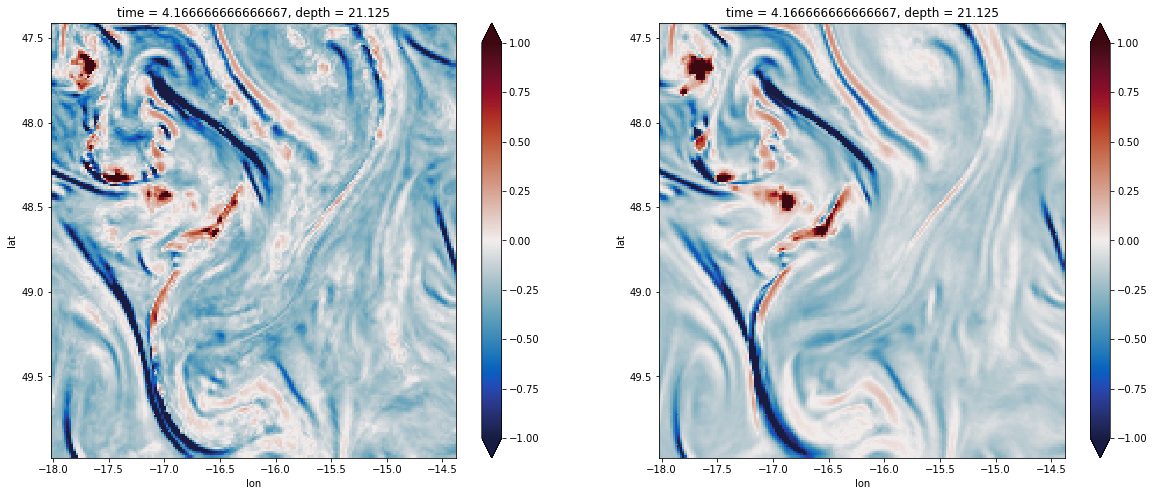

In [49]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
Ri.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)
plt.subplot(122)
Ri_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)

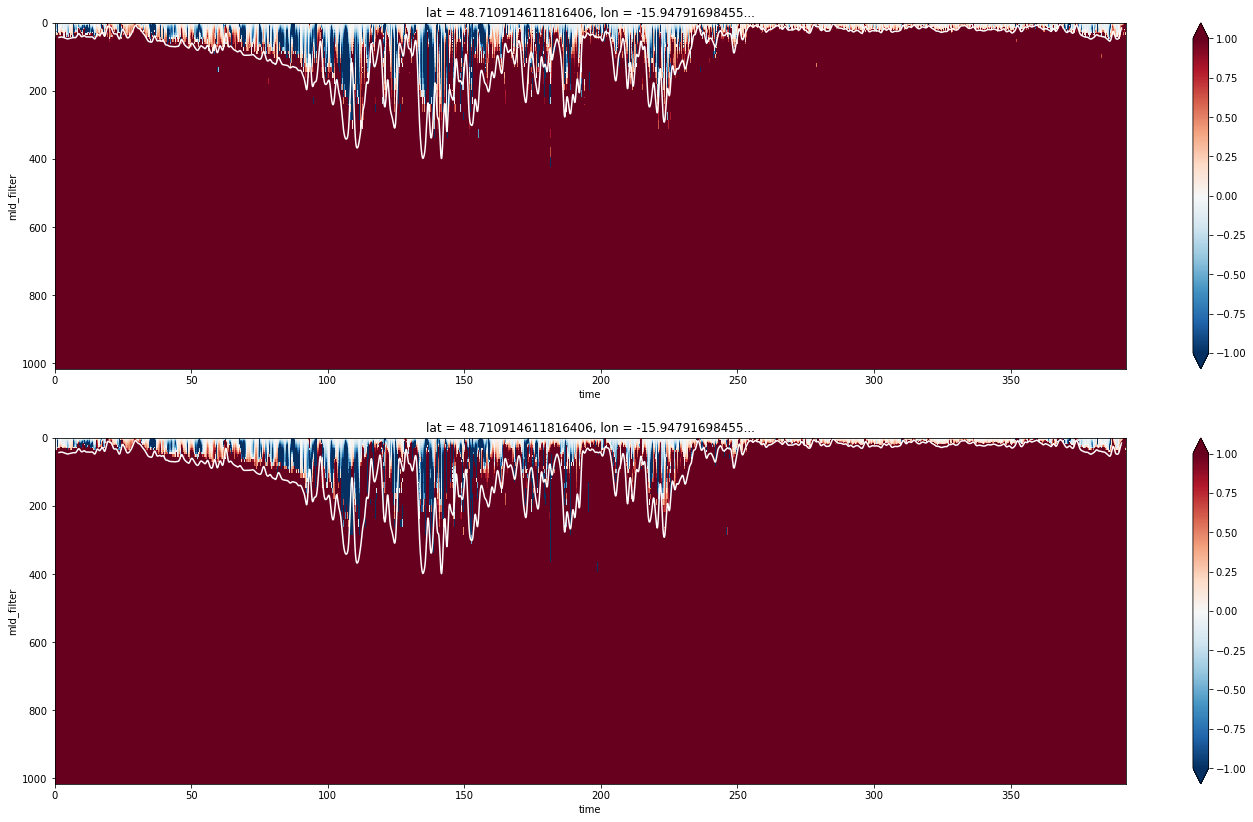

In [50]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
Ri.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

plt.subplot(212)
Ri_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

## 3.8 Frontogenesis function

In [30]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')

db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

du_dx_ij = gridx.diff(ds['U'], 'X')/gridx.interp(ds.dxG, 'Y')
du_dx_ij

dU_dy_1 = gridx.diff(ds['U'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')
du_dy_ij

dV_dx_1 = gridx.diff(ds['V'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')
dv_dx_ij

dv_dy_ij = gridx.diff(ds['V'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij

Fs = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)

In [31]:
db_dx_filter = gridx.diff(ds_filter['B_low_filter'],'X')/ds.dxC     # db/dx
db_dx_ij_filter = gridx.interp(db_dx_filter,'X')

db_dy_filter = gridx.diff(ds_filter['B_low_filter'],'Y')/ds.dyC     # db/dy
db_dy_ij_filter = gridx.interp(db_dy_filter,'Y')

du_dx_ij_filter = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds.dxG, 'Y')


dU_dy_1_filter = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2_filter = gridx.interp(dU_dy_1_filter, 'X')
du_dy_ij_filter = gridx.interp(dU_dy_2_filter, 'Y')

dV_dx_1_filter = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2_filter = gridx.interp(dV_dx_1_filter, 'X')
dv_dx_ij_filter = gridx.interp(dV_dx_2_filter, 'Y')

dv_dy_ij_filter = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij_filter

Fs_filter = -(du_dx_ij_filter*db_dx_ij_filter*db_dx_ij_filter + dv_dx_ij_filter*db_dx_ij_filter*db_dy_ij_filter + du_dy_ij_filter*db_dx_ij_filter*db_dy_ij_filter + dv_dy_ij_filter*db_dy_ij_filter*db_dy_ij_filter)
Fs_filter

<xarray.DataArray (time: 8761, depth: 40, lat: 201, lon: 177)>
dask.array<neg, shape=(8761, 40, 201, 177), dtype=float32, chunksize=(8761, 1, 1, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ... 2012-09-12
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 410.4 441.3 473.3 506.5
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

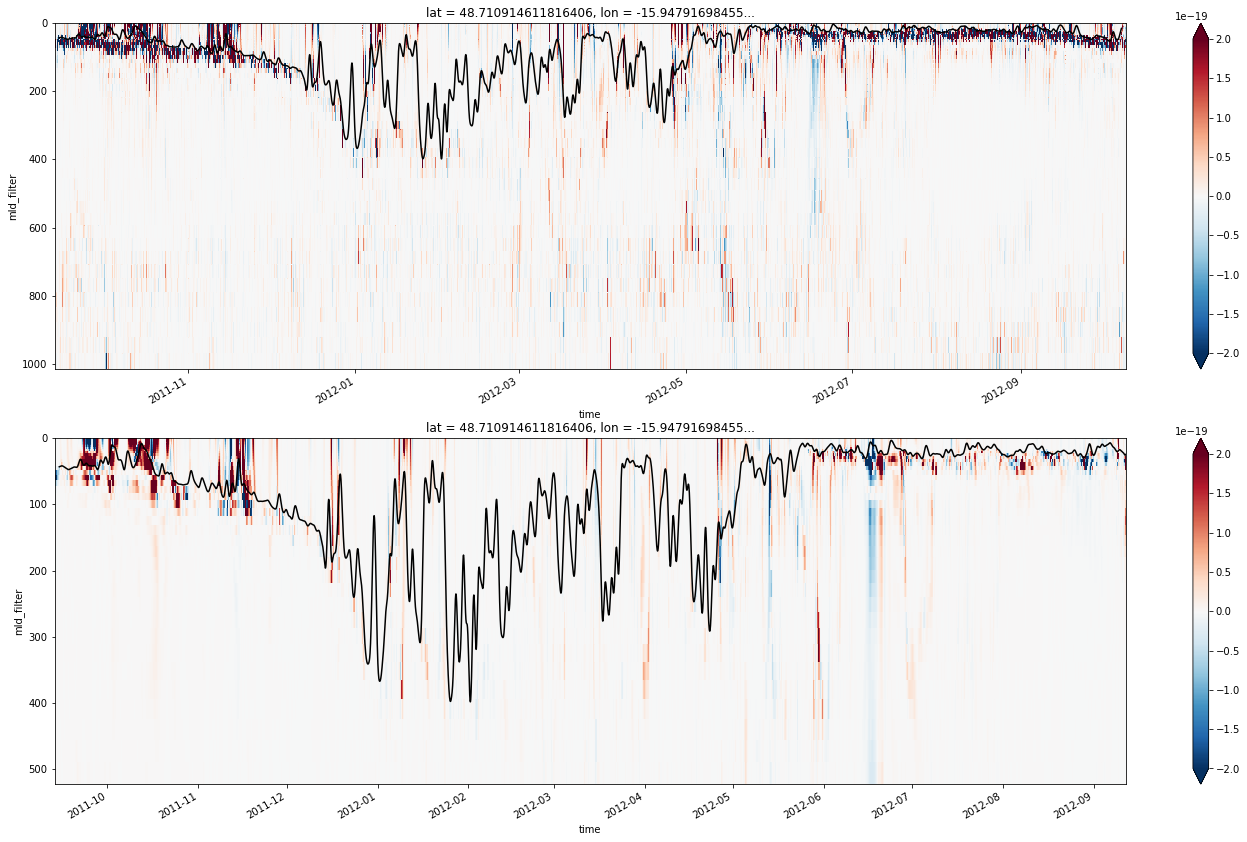

In [33]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
Fs.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-2e-19, vmax=2e-19, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
Fs_filter.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-2e-19, vmax=2e-19, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

In [44]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
